In [7]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [8]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

In [9]:
play_df = pd.read_csv('d20_intermediate_files/play_results.csv')
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv')
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv')

EmptyDataError: No columns to parse from file

In [10]:
play_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [6]:
play_df[['offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap', 'offense_a_presnap', 'offense_h_presnap']].plot.box()
play_df[['defense_p_presnap', 'defense_m_presnap', 'defense_v_presnap', 'defense_a_presnap', 'defense_h_presnap']].plot.box()

KeyError: "None of [Index(['offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap',\n       'offense_a_presnap', 'offense_h_presnap'],\n      dtype='object')] are in the [columns]"

In [7]:
from sklearn.cluster import KMeans

In [8]:
def string_to_vector(s):
    s = s.split('[')[1].split(']')[0]
    x = float(s.split()[0])
    y = float(s.split()[1])
    return np.array([x, y])

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [9]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)
# tracking_df['pos_delta'] = tracking_df.apply(lambda x: get_position_delta(x), axis=1)

NameError: name 'tracking_df' is not defined

In [10]:
# Attempt clustering of play data

In [11]:
km = KMeans(
    n_clusters=8, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(play_df.dropna())

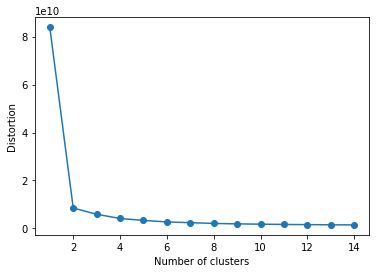

In [12]:
distortions = []
num_plays = play_df.dropna().shape[0]
num_plays = 15
for i in range(1, num_plays):
     km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
     km.fit(play_df.dropna())
     distortions.append(km.inertia_)

plt.plot(range(1, num_plays), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [13]:
play_df.columns

Index(['gameId', 'playId', 'offense_h_play', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end',
       'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw',
       'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_p_to_end', 'offense_m_play', 'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end',
       'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'offense_a_to_end', 'defense_p_play', 'defense_p_presnap',
       'defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end',
       'defense_m_play', 'defense_m_presnap', 'defense_m_to_throw',
       'defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play',
       'defense_v_presna

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

In [15]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
model = AgglomerativeClustering(linkage='ward',
                                distance_threshold=7,
                                n_clusters=None)
model.fit(df.drop(['gameId', 'playId'], axis=1))
df['cluster'] = model.labels_

In [16]:
df['cluster'].max()

3174

In [17]:
agglom_sizes = df.groupby('cluster').size()
agglom_sizes

cluster
0       3
1       3
2       5
3       3
4       2
       ..
3170    1
3171    1
3172    1
3173    1
3174    1
Length: 3175, dtype: int64

In [18]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for idx, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[idx] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

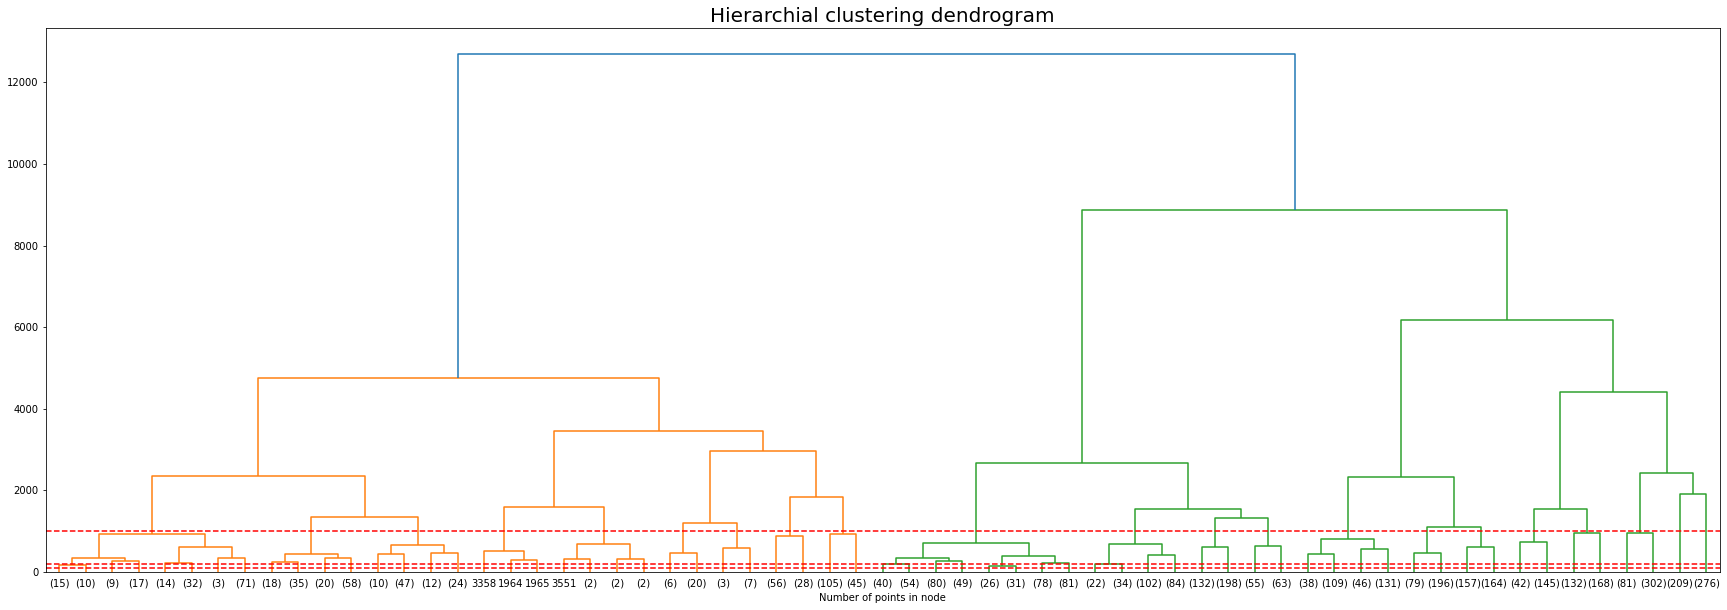

In [19]:
fig, ax = plt.subplots(figsize = (30, 10))
ax.set_title('Hierarchial clustering dendrogram', fontsize=20)
plot_dendrogram(model, truncate_mode='level', p=5)
plt.axhline(y=1000, color='r', linestyle='--')
plt.axhline(y=200, color='r', linestyle='--')
plt.axhline(y=100, color='r', linestyle='--')
plt.xticks(fontsize=10, rotation=0)
ax.set_xlabel('Number of points in node', fontsize=10)
plt.show()

In [20]:
play_df.loc[df.loc[df['cluster'] == 48].index.values[0]]['playId']

4592.0

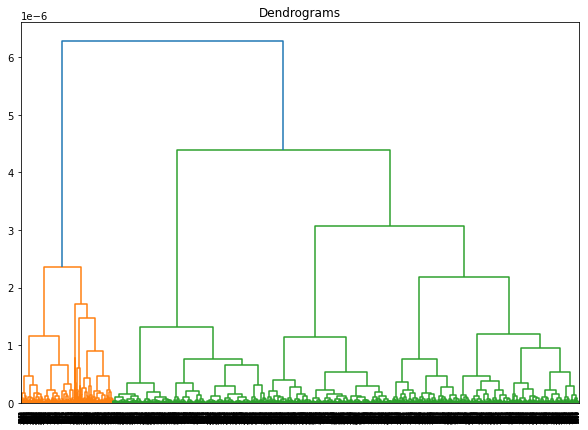

In [21]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(df_scaled.drop(['gameId', 'playId'], axis=1), method='ward'))

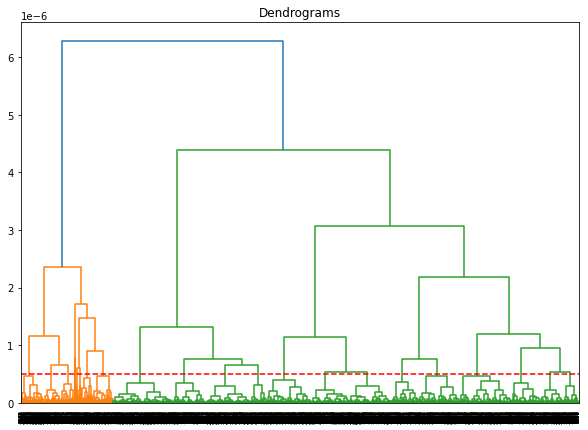

In [22]:
plt.figure(figsize=(10, 7))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(df_scaled.drop(['gameId', 'playId'], axis=1), method='ward'))
plt.axhline(y=0.0000005, color='r', linestyle='--')

In [23]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_scaled.drop(['gameId', 'playId'], axis=1))

array([2, 2, 2, ..., 3, 0, 4])

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_scaled['offense_h_presnap'], df_scaled['offense_h_to_throw'], c=cluster.labels_)

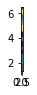

In [81]:
from itertools import combinations

stuff = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
pairs = []
for subset in combinations(stuff, 2):
    pairs.append(subset)
fig_cols = 3
fig_rows = int(np.ceil(len(pairs) / fig_cols))

plt.figure()
for i in range(1, fig_cols + 1):
    for j in range(1, fig_rows + 1):
        plt.subplot(i, j, 1)
        plt.scatter(df[pairs[0][0]], df[pairs[0][1]], c=cluster.labels_)


In [ ]:
stuff = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(stuff, 2):
    plt.figure(figsize=(10,7))
    plt.scatter(df[subset[0]], df[subset[1]], c=cluster.labels_)
    plt.xlabel(subset[0])
    plt.ylabel(subset[1])

In [31]:
df.drop(['gameId', 'playId'], axis=1).head()

,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_p_presnap,offense_p_to_throw,offense_p_to_arrived,offense_m_presnap,offense_m_to_throw,offense_m_to_arrived,offense_v_presnap,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,cluster
0,-0.000000,4.733452,4.306341,0.491735,0.586294,0.488032,0.455213,0.265324,0.393187,0.008809,...,0,0,0,0,0,0,0,0,0,2001
1,0.722081,4.249899,3.185872,0.466888,0.413593,0.501455,0.352721,0.198450,0.326194,0.053870,...,1,0,0,0,0,0,0,0,0,237
3,-0.000000,5.278721,4.789590,0.368274,0.272067,0.305495,0.325148,0.405869,0.245724,0.015400,...,0,0,0,0,1,1,0,0,0,1548
4,0.592412,3.949740,4.065981,0.521001,0.355874,0.586696,0.222165,0.272859,0.251324,0.052021,...,0,2,0,0,0,0,0,0,0,1354
5,0.856801,4.486656,4.609067,0.203906,0.588602,0.382720,0.103318,0.213341,0.597951,0.269083,...,0,0,0,0,0,0,1,0,0,3113


(array([3.322e+03, 0.000e+00, 5.770e+02, 0.000e+00, 0.000e+00, 1.530e+02,
        0.000e+00, 2.400e+01, 0.000e+00, 3.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

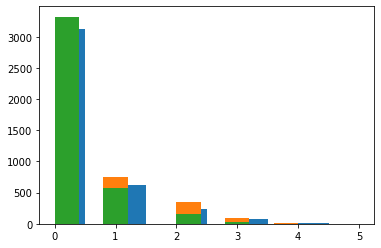

In [86]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

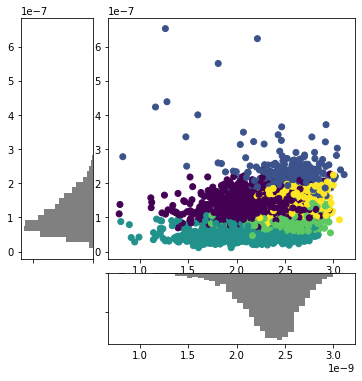

In [105]:
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

x = df_scaled['offense_h_to_throw']
y = df_scaled['offense_a_to_throw']
main_ax.scatter(x, y, c=cluster.labels_)

x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
y_hist.invert_xaxis()

In [128]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [129]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_h_to_throw'] * 10**10
y = df_scaled['offense_a_to_throw'] * 10**10
z = df_scaled['offense_p_to_throw'] * 10**10
ax.scatter3D(x, y, z, c=cluster.labels_)

<IPython.core.display.Javascript object>